## import Neccesary Libaries

In [52]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/e2/7b/8c1b410cd0604cee9a167a19f7e1746f5b92ae7d02ad574ab560b73c5a48/xgboost-2.1.1-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 131.3 kB/s eta 0:15:52
   ---------------------------------------- 0.0/124.9 MB 131.3 kB/s eta 0:15:52
   ---------------------------------------- 0.0/124.9 MB 131.3 kB/s eta 0:15:52
   ---------------------------------------- 0.0/124.9 MB 131.3 kB/s eta 0:15:52
   ---------------------------------------- 0.0/124.9 MB 103.4 kB/s eta 0:20:08
   -------------------------------------

In [69]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# import evaluation metrics
from sklearn.metrics import r2_score

# import pickle for saving and loading model
import pickle

## load the csv cleanes data to be used for prediction 

In [2]:
df = pd.read_csv("nigeriapropertywebscrapingI.csv")
df.head()

,property_title,property_type,address,description,price,bedroom,bathroom,toilet,Parking spaces,region
0,Exquisite 2bedroom Apartment,flat / apartment,"Lekki Enclave Road Nh1 Estate, Ikate, Lekki,...",Exquisite 2 bedroom apartment at ikate lekki l...,6000000,2,2,3,0,Ikate
1,Well Maintained 2bedroom Maisonette With 24/7 ...,terraced duplex,"Lekki Phase 1, Lekki, Lagos",A stylish 2-bedroom maisonette in lekki phase ...,11000000,2,2,3,2,Lekki
2,Serviced 4 Bedroom Terrace House With Bq,terraced duplex,"Off Nike Art Gallery Road Elegushi, Ikate, L...",Serviced luxury 4 bedroom terrace duplex in an...,10000000,4,4,5,3,Ikate
3,1 Bedroom Flat + Guest Toilet,mini flat (room and parlour),"Vgc Estate, VGC, Lekki, Lagos",Very spacious 1bed flat + guest toilet\nsemi f...,1500000,0,0,2,2,VGC
4,Self-serviced 2 Bedroom Flat (pent Floor) With...,flat / apartment,"Lekki Phase 1, Lekki, Lagos",Cw05775\nself-serviced 2 bedroom flat (pent fl...,4000000,2,2,3,0,Lekki


## EDA ANALYSIS

In [90]:
#calculate the average price
average_rent_by_region = df.groupby('region')['price'].mean().reset_index().sort_values(by='price', ascending=False)

print(average_rent_by_region)

                              region       price
94                      Allen Avenue  26550000.0
37                  Adjacent Chevron  26550000.0
111                 Apapa Expressway  26550000.0
594  Obasa Road Off Oba-akran Avenue  26550000.0
232                  By Gerrard Road  26550000.0
..                               ...         ...
86                           Alakija     15000.0
700                       Okokomaiko     15000.0
535            Maroko Police Station     13000.0
70               Ahmmadiyya Bus Stop     12000.0
411                            Ijora     10000.0

[934 rows x 2 columns]


In [91]:
#calculate the cheapest location 
df.groupby('region')['price'].min().reset_index().sort_values(by='price')

,region,price
417,Ikeja,2000
482,Lagos,2500
110,Apapa,3000
428,Ikoyi,7800
514,Lekki Phase 1,8500
...,...,...
10,5mins Off Admiralty Road.,26550000
705,Oladipupo Fafore St. Santos Layout,26550000
382,Harmony Estate,26550000
593,Obasa Road,26550000


In [92]:
#calculate the most expensive location 
df.groupby('region')['price'].max().reset_index().sort_values(by='price')

,region,price
411,Ijora,10000
70,Ahmmadiyya Bus Stop,12000
535,Maroko Police Station,13000
86,Alakija,15000
700,Okokomaiko,15000
...,...,...
730,Opebi,26550000
731,Opic,26550000
410,Ijesha,26550000
709,Ologolo,26550000


In [94]:
#average rent in the cheap regions and expensive regions
expensive_regions = ['Ijora', 'Ahmmadiyya Bus Stop', 'Maroko Police Station', 'Alakija','Okokomaiko','Opebi', 'Opic', 'Ijesha', 'Ologolo','Falomo']
cheap_regions = ['Ikeja', 'Lagos', 'Apapa', 'Ikoyi', 'Lekki Phase 1', '5mins Off Admiralty Road.', 'Oladipupo Fafore St. Santos Layout', 'Harmony Estate', 'Obasa Road', 'Maruwa Roundabout'] 

average_rent_expensive = df[df['region'].isin(expensive_regions)]['price'].mean()
average_rent_cheap = df[df['region'].isin(cheap_regions)]['price'].mean()

print(f"Average rent in expensive locations: {average_rent_expensive}")
print(f"Average rent in cheap locations: {average_rent_cheap}")

Average rent in expensive locations: 5941808.510638298
Average rent in cheap locations: 14676582.108098773


In [99]:
# Filter data for one-bedroom and two-bedroom flats
one_bedroom_rent = df[df['bedroom'] == 1].groupby('region')['price'].mean().reset_index()
two_bedroom_rent = df[df['bedroom'] == 2].groupby('region')['price'].mean().reset_index()

print("One-bedroom rent by region:")
print(one_bedroom_rent)

print("Two-bedroom rent by region:")
print(two_bedroom_rent)

One-bedroom rent by region:
Empty DataFrame
Columns: [region, price]
Index: []
Two-bedroom rent by region:
                          region         price
0           ( Bafaj) Off Awoyaya  2.500000e+06
1                          Abijo  1.525000e+06
2                          Aboru  1.150000e+06
3               Abraham Adesanya  2.336364e+06
4        Abraham Adesanya Estate  2.750000e+06
..                           ...           ...
292                        marwa  4.500000e+06
293                     olokonla  1.800000e+06
294             opp Crown Estate  1.500000e+06
295          paradise 2 Estate .  4.000000e+06
296  rain Oil Filling Station...  1.200000e+06

[297 rows x 2 columns]


In [110]:
df.corr(numeric_only=True)

,price,bedroom,bathroom,toilet,Parking spaces
price,1.000000,0.477926,0.368170,0.104780,0.051194
bedroom,0.477926,1.000000,0.767664,0.186819,0.141375
bathroom,0.368170,0.767664,1.000000,0.200294,0.296054
toilet,0.104780,0.186819,0.200294,1.000000,0.062988
Parking spaces,0.051194,0.141375,0.296054,0.062988,1.000000


## handle outliers
consider price, bedrooms, bathrooms, park_spaces, toilets

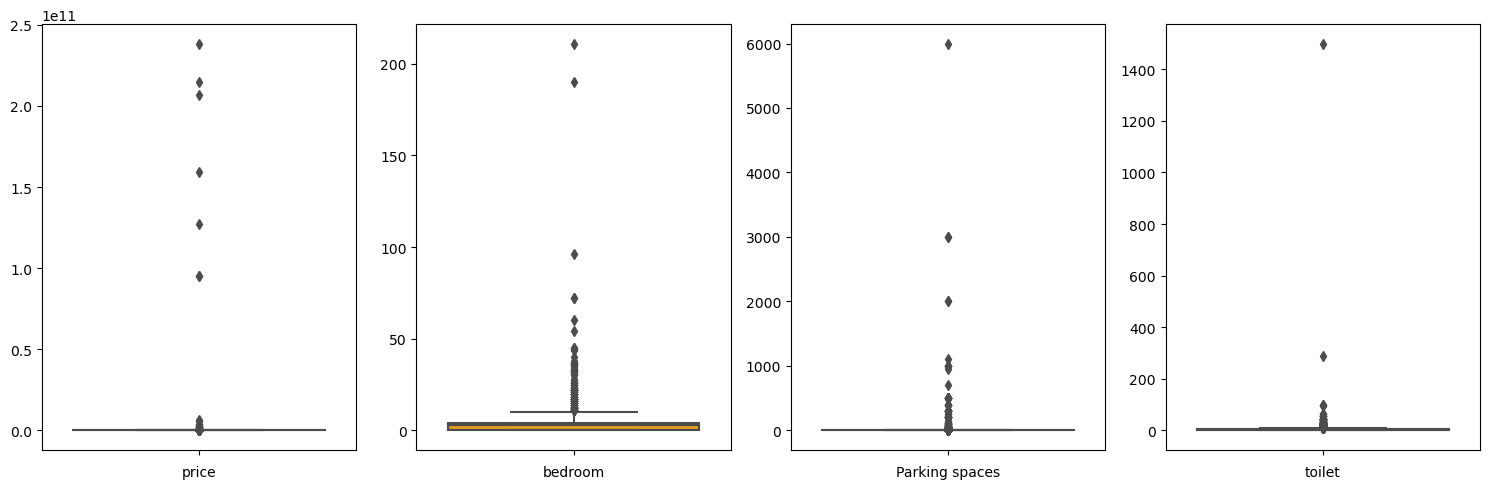

In [21]:
numerical_columns = ["price", "bedroom", "Parking spaces", "toilet"]
fig , axarr = plt.subplots(1,4, figsize= (15, 5))
n=0
for col in numerical_columns:
    ax = axarr[n]
    sns.boxplot(y=df[col], color="orange", ax=ax)bb
    ax.set_xlabel(col)
    ax.set_ylabel("")
    n +=1
    
plt.tight_layout()
plt.show()

## we will be removing outliers in the column 

## Removing outliers 

In [34]:
def remove_outliers(data):
    """
    This function returns the total outliers in a dataframe column
    and replace the upper and lower outliers using interquatile range(IQR)
    """
    # calculate the third quartile
    Q3 = data.quantile(0.75)
    
    # calculate the first quartile
    Q1 = data.quantile(0.25)
    
    # calculate the IQR
    IQR = Q3 -Q1
    
    # calculate lower fence
    lower_fence = round(Q1 - 1.5*IQR)
                        
                        
    # calculate upper fence 
    upper_fence = round(Q3 + 1.5*IQR)
    
    # replacing the lower outliers with the lower IQR value
    data.loc[data<lower_fence] = lower_fence
    
    # replacing the upper outliers with the upper IQR value
    data.loc[data>upper_fence] = upper_fence
    
    
    return data

In [35]:
# Remove outliers in each column
df["price"] = remove_outliers(df["price"])
df["bathroom"] = remove_outliers(df["bathroom"])
df["bedroom"] =remove_outliers(df["bedroom"])
df["Parking spaces"] = remove_outliers(df["Parking spaces"])

C:\Users\PC\AppData\Local\Temp\ipykernel_8484\435363786.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data<lower_fence] = lower_fence
C:\Users\PC\AppData\Local\Temp\ipykernel_8484\435363786.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data>upper_fence] = upper_fence
C:\Users\PC\AppData\Local\Temp\ipykernel_8484\435363786.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data<lower_fence] = l

0
1
2
3


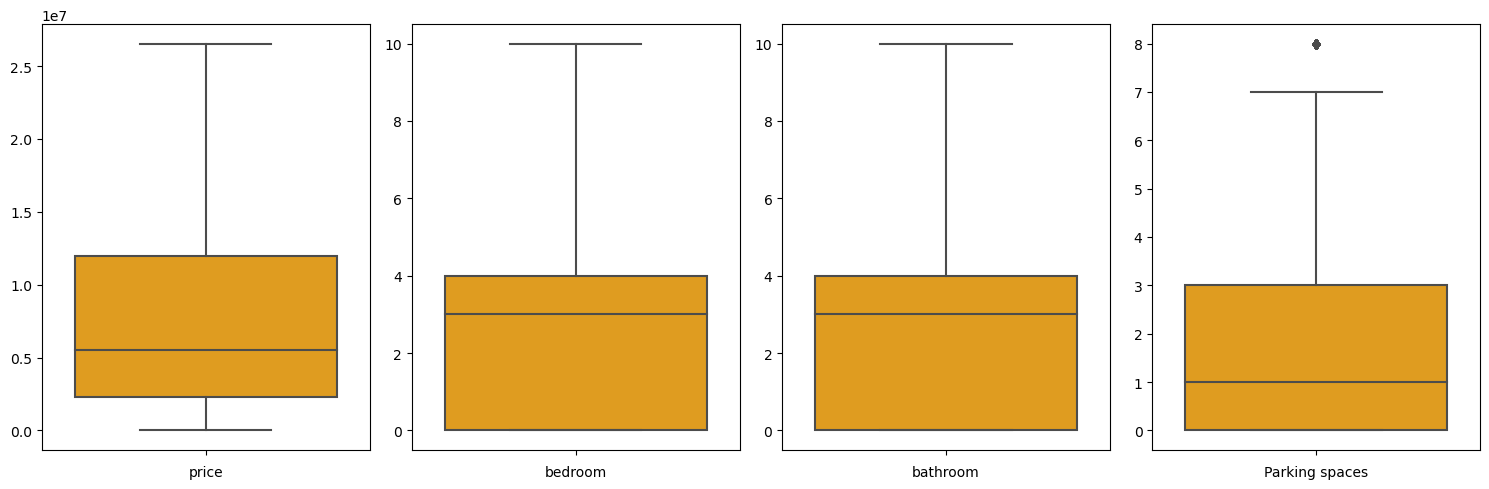

In [38]:
numerical_columns = ["price", "bedroom", "bathroom", "Parking spaces", "toilet"]
fig, axarr = plt.subplots(1,4, figsize=(15,5))

n= 0
for col in numerical_columns:
    print(n)
    ax = axarr[n]
    sns.boxplot(y=df[col], color="orange", ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel("")
    n += 1
    if n == 4:
        break
    
    
plt.tight_layout()
plt.show()

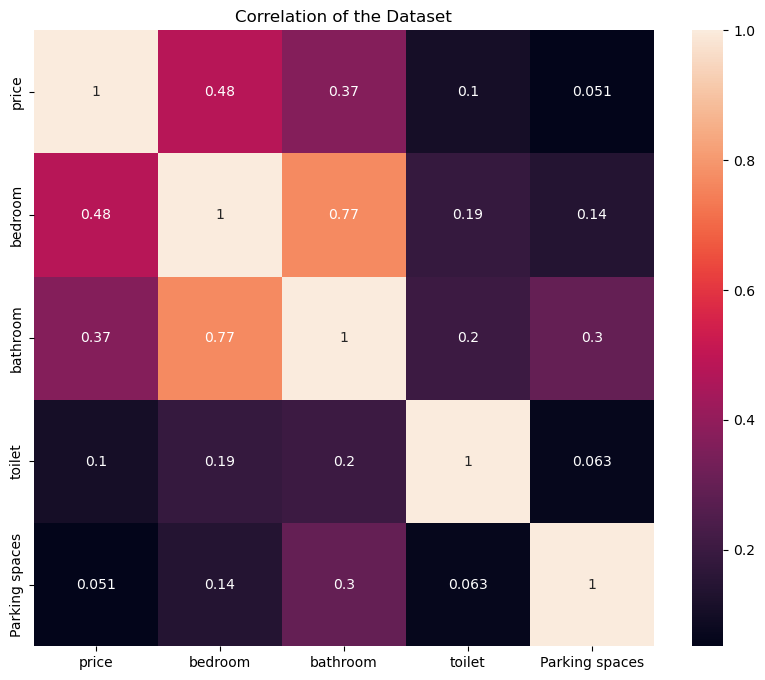

In [40]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.title("Correlation of the Dataset")
plt.show()

C:\Users\PC\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1000x800 with 0 Axes>

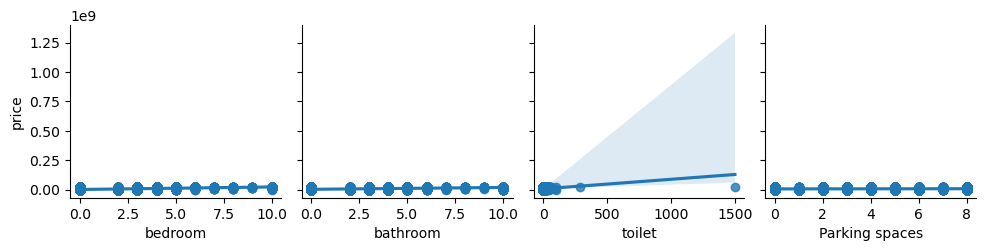

In [42]:
#lets visualize the corellation

columns = ["bedroom", "bathroom", "toilet","Parking spaces"]

plt.figure(figsize=(10, 8))
sns.pairplot(data=df, x_vars=columns, y_vars="price", diag_kind="hist", kind="reg")
plt.show

In [45]:
extract_df = df[["property_type", "price", "bedroom", "bathroom", "toilet", "Parking spaces", "region"]]

In [46]:
extract_df

,property_type,price,bedroom,bathroom,toilet,Parking spaces,region
0,flat / apartment,6000000,2,2,3,0,Ikate
1,terraced duplex,11000000,2,2,3,2,Lekki
2,terraced duplex,10000000,4,4,5,3,Ikate
3,mini flat (room and parlour),1500000,0,0,2,2,VGC
4,flat / apartment,4000000,2,2,3,0,Lekki
...,...,...,...,...,...,...,...
22317,terraced duplex,2200000,3,3,4,4,Ajah
22318,Shop,2500000,0,0,0,0,Lekki Phase 1
22319,Plaza / complex / mall,3000000,0,0,0,8,Lekki Phase 1
22320,Plaza / complex / mall,3500000,0,0,0,8,Lekki Phase 1


In [47]:
x = extract_df.drop(columns=["price"])
y = extract_df["price"]

In [49]:
x.head()

,property_type,bedroom,bathroom,toilet,Parking spaces,region
0,flat / apartment,2,2,3,0,Ikate
1,terraced duplex,2,2,3,2,Lekki
2,terraced duplex,4,4,5,3,Ikate
3,mini flat (room and parlour),0,0,2,2,VGC
4,flat / apartment,2,2,3,0,Lekki


## split data into train and test

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 1)

In [64]:
X_train.shape

(17857, 4)

In [65]:
X_test.shape

(4465, 4)

In [66]:
y_train.shape

(17857,)

In [67]:
y_test.shape

(4465,)

## one hot encoding and standard scaling

In [74]:
column_trans = make_column_transformer((OneHotEncoder(sparse=False, handle_unknown='ignore'), ["property_type", "region"]), remainder="passthrough")
column_trans

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['property_type', 'region'])])

## Linear Regression Model

In [75]:
# create the pipeline with column transformer and scaler
# Define the pipeline including the scaler
pipeline= Pipeline(steps=[
    ('preprocessor', column_trans),
    ('scaler', StandardScaler()), # scalar
    ('model', LinearRegression())
])


#fit the pipeline on te training data
pipeline.fit(x_train, y_train)

# make predictions on the test data
lr_y_pred = pipeline.predict(x_test)

# calculate the evaluation between the actual value and predicted value
accuracy_score = r2_score(y_test, lr_y_pred)

# print the evaluation metrics
print(f"R-squared Score: {accuracy_score}")

C:\Users\PC\anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


R-squared Score: -1.7837736096816054e+20


## lasso regression model

In [77]:
#create  d pipeline with  create the pipeline with column transformer and scaler
# Define the pipeline including the scaler
pipeline= Pipeline(steps=[
    ('preprocessor', column_trans),
    ('scaler', StandardScaler()), # scalar
    ('model', Lasso())
])


#fit the pipeline on te training data
pipeline.fit(x_train, y_train)

# make predictions on the test data
lasso_y_pred = pipeline.predict(x_test)

# calculate the evaluation between the actual value and predicted value
accuracy_score = r2_score(y_test, lasso_y_pred)

# print the evaluation metrics
print(f"R-squared Score: {accuracy_score}")

C:\Users\PC\anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


R-squared Score: 0.569565961356101


C:\Users\PC\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.310e+17, tolerance: 1.222e+14
  model = cd_fast.enet_coordinate_descent(


## GradientBosting model

In [79]:
#create the pipeline with column transformer and scaler
# Define the pipeline including the scaler
pipeline= Pipeline(steps=[
    ('preprocessor', column_trans),
    ('scaler', StandardScaler()), # scalar
    ('model', GradientBoostingRegressor())
])


#fit the pipeline on te training data
pipeline.fit(x_train, y_train)

# make predictions on the test data
gbr_y_pred = pipeline.predict(x_test)

# calculate the evaluation between the actual value and predicted value
accuracy_score = r2_score(y_test, gbr_y_pred)

# print the evaluation metrics
print(f"R-squared Score: {accuracy_score}")

C:\Users\PC\anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


R-squared Score: 0.5870826423825306


## Randomforestregressormodel

In [81]:
#create the pipeline with column transformer and scaler
# Define the pipeline including the scaler
pipeline= Pipeline(steps=[
    ('preprocessor', column_trans),
    ('scaler', StandardScaler()), # scalar
    ('model', RandomForestRegressor())
])


#fit the pipeline on te training data
pipeline.fit(x_train, y_train)

# make predictions on the test data
rfr_y_pred = pipeline.predict(x_test)

# calculate the evaluation between the actual value and predicted value
accuracy_score = r2_score(y_test, rfr_y_pred)

# print the evaluation metrics
print(f"R-squared Score: {accuracy_score}")

C:\Users\PC\anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


R-squared Score: 0.5960907423599188


## DecisionTreeRegressormodel

In [84]:
#create the pipeline with column transformer and scaler
# Define the pipeline including the scaler
pipeline= Pipeline(steps=[
    ('preprocessor', column_trans),
    ('scaler', StandardScaler()), # scalar
    ('model', DecisionTreeRegressor())
])


#fit the pipeline on te training data
pipeline.fit(x_train, y_train)

# make predictions on the test data
dtr_y_pred = pipeline.predict(x_test)

# calculate the evaluation between the actual value and predicted value
accuracy_score = r2_score(y_test, dtr_y_pred)

# print the evaluation metrics
print(f"R-squared Score: {accuracy_score}")

C:\Users\PC\anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


R-squared Score: 0.5417731785113391


## XGBReressor model

In [82]:
#create the pipeline with column transformer and scaler
# Define the pipeline including the scaler
pipeline= Pipeline(steps=[
    ('preprocessor', column_trans),
    ('scaler', StandardScaler()), # scalar
    ('model', xgb.XGBRegressor())
])


#fit the pipeline on te training data
pipeline.fit(x_train, y_train)

# make predictions on the test data
xgb_y_pred = pipeline.predict(x_test)

# calculate the evaluation between the actual value and predicted value
accuracy_score = r2_score(y_test, xgb_y_pred)

# print the evaluation metrics
print(f"R-squared Score: {accuracy_score}")

C:\Users\PC\anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


R-squared Score: 0.6293039018174079


## save model

In [86]:
pickle.dump(pipeline, open("model.pickle", 'wb'))

In [87]:
##it used the last pipeline cause thats the one we picked that sice its more accurate

In [114]:
import sklearn

In [115]:
sklearn.__version__

'1.3.0'

In [116]:
!pip install streamlit

  Obtaining dependency information for streamlit from https://files.pythonhosted.org/packages/b0/68/cf905fd2db4a84dc9b46803512b9765a3e9a6dfaa378a67c8db910c44ab3/streamlit-1.37.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for altair<6,>=4.0 from https://files.pythonhosted.org/packages/07/92/485d136f850e89e5dd0b60047b539453c50be3782308447a4951fe2dc6bd/altair-5.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for blinker<2,>=1.0.0 from https://files.pythonhosted.org/packages/bb/2a/10164ed1f31196a2f7f3799368a821765c62851ead0e630ab52b8e14b4d0/blinker-1.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for cachetools<6,>=4.0 from https://files.pythonhosted.org/packages/a4/07/14f8ad37f2d12a5ce41206c21820d8cb6561b728e51fad4530dff0552a67/cachetools-5.5.0-py3-none-any.whl.metadata
  Obtaining dependency information for gitpython!=3.1.19,<4,>=3.0.7 from https://files.pythonhosted.org/packages/e9/bd/cc3a402a6439c15c3d4294333e13042b915bbeab54edc4